In [1]:
#  Imports

import os, pickle, time

import numpy as np
import tensorflow as tf

from keras.layers      import Dense, Input, LeakyReLU
from keras.models      import Model
from keras.callbacks   import Callback, EarlyStopping
from keras.optimizers  import Adam, SGD, Adadelta

from matplotlib import pyplot as plt

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [109]:
#  Config

load_models = True

num_hidden_layers   = 5
num_nodes_per_layer = 100

num_datapoints = int(2e3)

random_seed = 100

epochs     = 100000
batch_size = 50

initial_lr = 1e-3

In [95]:
#  Generate toy data

def true_func (x) :
    x = x*10
    return ((5. + 15.*np.sin(3.*x) + 6*x  + 1.*x*x) - 62.5) / 80.

def sample (num_pts, precision=0.01) :
    np.random.seed(random_seed)
    x = np.random.uniform(low=-1, high=1., size=(num_pts,))
    y = true_func(x)
    u = 3.*np.random.normal(size=(num_pts,))/80.
    return np.array([x, y + u]).transpose()
    
true_data = sample(num_datapoints)

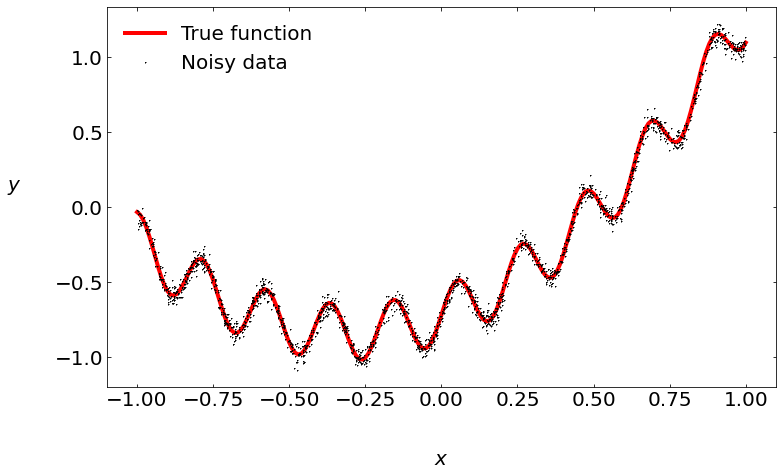

In [96]:
#  Plot toy data

x = np.linspace(-1, 1, 201)
y = true_func(x)

fig = plt.figure(figsize=(12, 7))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(x, y, "-", c="red", lw=4, label="True function")
ax.plot(true_data[:,0], true_data[:,1], "+", c="k", markersize=1, label="Noisy data")
ax.set_xlabel("$x$", fontsize=20, labelpad=40)
ax.set_ylabel("$y$", fontsize=20, labelpad=40, rotation=0)
ax.legend(loc="upper left", fontsize=20, frameon=False)
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=20)
plt.show()


In [135]:
#  Create ensemble of models

input_layer = Input(1)
output_layer = input_layer
for layer_idx in range(num_hidden_layers) :
    output_layer = Dense    (num_nodes_per_layer)(output_layer)
    output_layer = LeakyReLU(0.2)                (output_layer)
output_layer = Dense(1, activation="linear")(output_layer)
model = Model(input_layer, output_layer, name=f"Model_{num_hidden_layers}layers_{num_nodes_per_layer}nodes")
model.compile(loss="mse", optimizer=Adam(lr=initial_lr))
model.summary()
    

Model: "Model_5layers_100nodes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_102 (Dense)            (None, 100)               200       
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 100)    

In [136]:
#  Define callback class

class EvolvingLearningRate (Callback) :
    """Reduce the learning rate when the monitoring metric stops improving.

  Arguments:
      factor: Factor by which the lr is multiplied at each update.
      min_delta: Smallest tolerated improvement in the monitor.
      monitor: Metric to be monitored for improvement.
      patience: Number of epochs the monitor must improve over.
  """

    def __init__(self, factor=0.5, min_delta=0, min_lr=0, monitor="none", patience=0):
        super(EvolvingLearningRate, self).__init__()
        self.factor    = factor
        self.min_delta = min_delta
        self.min_lr    = min_lr
        self.monitor   = monitor
        self.patience  = patience

    def on_train_begin(self, logs=None):
        self.epochs_since_min = 0
        self.monitor_best_val = np.inf
        self.learning_rate    = self.model.optimizer.learning_rate
        self.initial_lr       = self.learning_rate.eval(session=tf.compat.v1.keras.backend.get_session())
        self.model.lr_record  = [(0, self.learning_rate)]

    def on_epoch_end(self, epoch, logs=None):
        if self.monitor == "none" :
            if "val_loss" in logs :
                print(" - no monitor metric set, defaulting to val_loss")
                self.monitor = "val_loss"
            elif "loss" in logs : 
                print(" - no monitor metric set, defaulting to loss as val_loss is not available")
                self.monitor = "loss"
            else :
                raise ValueError(f"No monitor metric set")
        monitor_val = logs.get(self.monitor)
        if monitor_val < self.monitor_best_val :
            self.monitor_best_val = monitor_val
            self.epochs_since_min = 0
        else:
            self.epochs_since_min += 1
            if self.epochs_since_min >= self.patience :
                session    = tf.compat.v1.keras.backend.get_session()
                current_lr = self.learning_rate.eval(session=session)
                new_lr     = np.max([self.factor*current_lr, self.min_lr])
                session.run(self.learning_rate.assign(new_lr))
                self.monitor_best_val = monitor_val
                self.epochs_since_min = 0
                self.model.lr_record.append((epoch, new_lr))

    def on_train_end(self, logs=None) :
        session = tf.compat.v1.keras.backend.get_session()
        session.run(self.learning_rate.assign(self.initial_lr))
        

In [137]:
#  Define method for plotting an ensemble of models

def plot_model(model) :
    fig = plt.figure(figsize=(12, 7))
    ax  = fig.add_subplot(1, 1, 1)
    x = np.linspace(-1, 1, 201)
    y = model.predict(x)
    ax.plot(x, y, "-", lw=4, alpha=0.5)
    ax.plot(true_data[:,0], true_data[:,1], "+", c="k", markersize=1, label="Noisy data")
    ax.set_xlabel("$x$", fontsize=20, labelpad=40)
    ax.set_ylabel("$y$", fontsize=20, labelpad=40, rotation=0)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(loc="upper left", fontsize=16, frameon=False)
    ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=20)
    plt.show()

In [138]:
#  Train model

#callbacks = [EarlyStopping(monitor="loss", patience=50, restore_best_weights=True)]

callbacks = [EvolvingLearningRate(patience=20), EarlyStopping(monitor="loss", patience=50,  restore_best_weights=True, min_delta=1e-5)]

train_record = model.fit(
          true_data[:,0], 
          true_data[:,1], 
          epochs           = epochs      , 
          shuffle          = True        ,
          batch_size       = batch_size  ,
          callbacks        = callbacks
         )
    
# EvolvingLearningRate(patience=3)


Train on 2000 samples
Epoch 1/100000
2000/2000 [==============================] - 0s 68us/sample - loss: 0.1176
Epoch 2/100000
2000/2000 [==============================] - 0s 33us/sample - loss: 0.0233
Epoch 3/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0197
Epoch 4/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0197
Epoch 5/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0201
Epoch 6/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0198
Epoch 7/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0196
Epoch 8/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0188
Epoch 9/100000
2000/2000 [==============================] - 0s 30us/sample - loss: 0.0185
Epoch 10/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0192
Epoch 11/100000
2000/2000 [==============================] - 0s 27us/sample -

2000/2000 [==============================] - 0s 26us/sample - loss: 0.0050
Epoch 90/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0043
Epoch 91/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0043
Epoch 92/100000
2000/2000 [==============================] - 0s 26us/sample - loss: 0.0049
Epoch 93/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0093
Epoch 94/100000
2000/2000 [==============================] - 0s 31us/sample - loss: 0.0044
Epoch 95/100000
2000/2000 [==============================] - 0s 30us/sample - loss: 0.0053
Epoch 96/100000
2000/2000 [==============================] - 0s 30us/sample - loss: 0.0035
Epoch 97/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0033
Epoch 98/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0029
Epoch 99/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0027
Epoch 100/10000

2000/2000 [==============================] - 0s 27us/sample - loss: 0.0019
Epoch 179/100000
2000/2000 [==============================] - 0s 26us/sample - loss: 0.0019
Epoch 180/100000
2000/2000 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 181/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0021
Epoch 182/100000
2000/2000 [==============================] - 0s 30us/sample - loss: 0.0020
Epoch 183/100000
2000/2000 [==============================] - 0s 30us/sample - loss: 0.0018
Epoch 184/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0018
Epoch 185/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0019
Epoch 186/100000
2000/2000 [==============================] - 0s 26us/sample - loss: 0.0020
Epoch 187/100000
2000/2000 [==============================] - 0s 26us/sample - loss: 0.0018
Epoch 188/100000
2000/2000 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch

2000/2000 [==============================] - 0s 27us/sample - loss: 0.0014
Epoch 268/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0015
Epoch 269/100000
2000/2000 [==============================] - 0s 27us/sample - loss: 0.0015
Epoch 270/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0015
Epoch 271/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0015
Epoch 272/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0015
Epoch 273/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0015
Epoch 274/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0014
Epoch 275/100000
2000/2000 [==============================] - 0s 29us/sample - loss: 0.0014
Epoch 276/100000
2000/2000 [==============================] - 0s 28us/sample - loss: 0.0014
Epoch 277/100000
2000/2000 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch

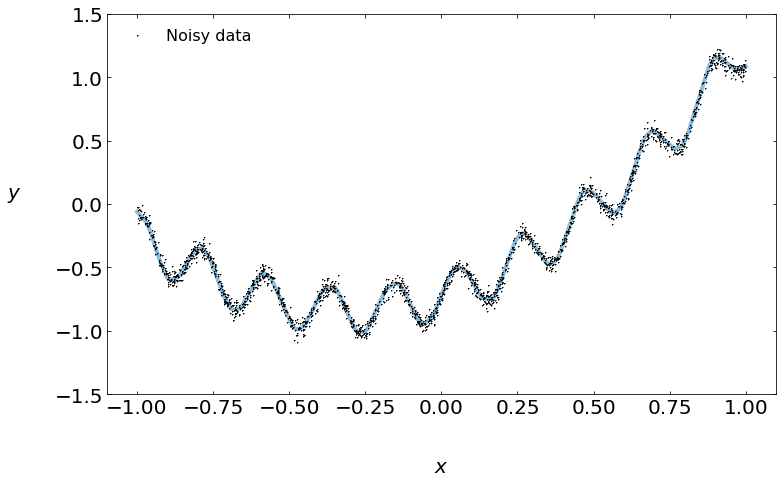

In [139]:
#  Plot model

plot_model(model)


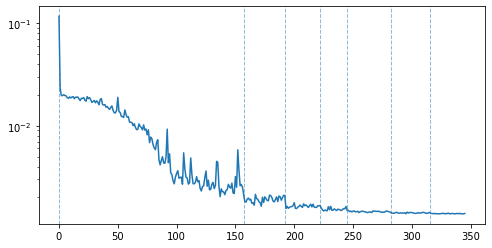

In [140]:
fig = plt.figure(figsize=(8, 4))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_record.history["loss"])
for lr_itr in model.lr_record :
    ax.axvline(lr_itr[0], lw=1, ls="--", alpha=0.5)
ax.set_yscale("log")
plt.show()